# Demo of `litholog` functionality

litholog is a package-level extension of agile-geoscience/striplog, with additional features that focus on lithology, and an API that is geared toward facilitating machine learning and quantitative analysis.

The package provides two primary data structures:

- `Bed`
    - stores data from one bed (e.g., top, base, lithology, thickness, grain size, etc).
    - is equivalent to a `striplog.Interval`

- `BedSequence`
    - stores a collection of `Beds` in stratigraphic order 
    - is equivalent to a `striplog.Striplog`


Other utilities include:
- transformations for grain-size data from millimeter (mm) to log2 (a.k.a. Psi) units, which are far easier to work with than mm. 
- calculation of the following metrics at the `BedSequence` level:
    - net-to-gross
    - amalgamation ratio
    - psuedo gamma ray log
    - Hurst statistics (for determining facies clustering)
- default lithology colors

The data provided with this demo come from two papers, and all logs were digitized using the Matlab digitizer included with this release.
- 19 logs from Jobe et al. 2012 ([html](https://doi.org/10.1111/j.1365-3091.2011.01283.x), [pdf](https://www.dropbox.com/s/sgzmc1exd5vjd3h/2012%20Jobe%20et%20al%20Sed-%20Climbing%20ripple%20successions%20in%20turbidite%20systems.pdf?dl=0))
- 11 logs from Jobe et al. 2010 ([html](https://doi.org/10.2110/jsr.2010.092), [pdf](https://www.dropbox.com/s/zo12v3ixm86yt7e/2010%20Jobe%20et%20al%20JSR%20-%20Submarine%20channel%20asymmetry.pdf?dl=0)), 

An example log from that paper is shown here, drafted in a vector-drawing program:
<img src="../images/example_log.png" alt="Example graphic log from Jobe et al. (2012)" width="500"/>

When plotted with litholog looks like this:


---
---


## Import some packages, including `litholog`

In [1]:
import collections
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import litholog
from litholog import utils, Bed
from litholog.sequence import io, BedSequence

from striplog import Component

# Demo data

## Load the raw `csv` data

This first step uses `utils` within litholog to converts depth-grainsize pairs (e.g., that define a fining-upward profile in a bed) into pandas-friendly arrays. The outputs of this will be the fields shown below (e.g., `depth_m`, `grain_size_mm`). If you have differently formatted csv data, this step may not apply, or you may need a different util.

In [2]:
# Converts 'string' arrays to numpy
transforms = {c : utils.string2array_pandas for c in ['depth_m', 
                                                      'grain_size_mm']}

# Read the demo data
df = pd.read_csv('../data/working2.csv', converters=transforms)

# counts and prints the names of the logs in the data file
print(len(df.name.unique()),
      'graphic logs imported:',
      '\n',
      df.name.unique()) 

df.head() # displays the first five rows of data

13 graphic logs imported: 
 ['Karoo krf1' 'Karoo krf2' 'Karoo krf3' 'Karoo krf4' 'Karoo krf5'
 'Magnolia' 'Pukearuhue' 'Sierra del Toro dc1' 'Sierra del Toro dc2'
 'Sierra del Toro flame' 'Sierra del Toro h2o' 'Sierra del Toro ssm'
 'Sierra del Toro wc']


,name,collection,tops,th,gs_tops_mm,snd_shl,mean_gs_mm,max_gs_mm,ng,ar,depth_m,grain_size_mm
0,Karoo krf1,Skoorsteenberg,21.042456,0.392483,0.147378,1.0,0.147378,0.147378,0.772615,0.104762,"[21.0425, 20.65]","[0.1474, 0.1474]"
1,Karoo krf1,Skoorsteenberg,20.649974,0.244327,0.009271,0.0,0.009271,0.009271,0.772615,0.104762,"[20.65, 20.4056]","[0.0093, 0.0093]"
2,Karoo krf1,Skoorsteenberg,20.405647,0.041588,0.122473,1.0,0.122473,0.122473,0.772615,0.104762,"[20.4056, 20.3641]","[0.1225, 0.1225]"
3,Karoo krf1,Skoorsteenberg,20.364059,0.046786,0.009271,0.0,0.009271,0.009271,0.772615,0.104762,"[20.3641, 20.3173]","[0.0093, 0.0093]"
4,Karoo krf1,Skoorsteenberg,20.317273,0.106568,0.128978,1.0,0.128978,0.128978,0.772615,0.104762,"[20.3173, 20.2107]","[0.129, 0.129]"


The variable `df` is just a pandas DataFrame at this point - it hasn't been put into `litholog` format yet. 

Notice that the columns `ng` (net-to-gross) and `ar` (amalgamation ratio) are the same for each graphic log. This csv was processed using Matlab, and `ng` and `ar` were calculated there. Not to worry, `litholog` can also calculate these metrics, which we will show you how to do below. 

Before we translate the dataframe into `BedSequences`, let's create a log2 grain-size column. We will use the functionality of `wentworth` to do this, and we will create PSI units instead of PHI units, because they increase with increasing grain size. We simply take the `grain_size_mm` column and translate it to psi units (`grain_size_psi`): 

In [3]:
df['grain_size_psi'] = df.grain_size_mm.apply(lambda x: np.round(litholog.wentworth.gs2psi(x),4))
df.head()

,name,collection,tops,th,gs_tops_mm,snd_shl,mean_gs_mm,max_gs_mm,ng,ar,depth_m,grain_size_mm,grain_size_psi
0,Karoo krf1,Skoorsteenberg,21.042456,0.392483,0.147378,1.0,0.147378,0.147378,0.772615,0.104762,"[21.0425, 20.65]","[0.1474, 0.1474]","[-2.7622, -2.7622]"
1,Karoo krf1,Skoorsteenberg,20.649974,0.244327,0.009271,0.0,0.009271,0.009271,0.772615,0.104762,"[20.65, 20.4056]","[0.0093, 0.0093]","[-6.7486, -6.7486]"
2,Karoo krf1,Skoorsteenberg,20.405647,0.041588,0.122473,1.0,0.122473,0.122473,0.772615,0.104762,"[20.4056, 20.3641]","[0.1225, 0.1225]","[-3.0291, -3.0291]"
3,Karoo krf1,Skoorsteenberg,20.364059,0.046786,0.009271,0.0,0.009271,0.009271,0.772615,0.104762,"[20.3641, 20.3173]","[0.0093, 0.0093]","[-6.7486, -6.7486]"
4,Karoo krf1,Skoorsteenberg,20.317273,0.106568,0.128978,1.0,0.128978,0.128978,0.772615,0.104762,"[20.3173, 20.2107]","[0.129, 0.129]","[-2.9546, -2.9546]"



--- 

---

## Convert dataframe groups to `BedSequence`s

This is the step that will convert our dataframe into `BedSequences` (equivalent to a `striplog.Striplog`) that contains `Beds` (equivalent to `striplog.Intervals`).

The component map sets the `primary` data for each `Bed` - see other ways to do this in the `litholog_basics.ipynb`



In [4]:
# Columns shared by whole sequences (i.e., shared by an entire graphic log)
METACOLS = ['name', 'collection', 'ng', 'ar']

# Columns of bed-level data, including the psi column we just made
DATACOLS = ['th', 'gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm','grain_size_psi']

# Convert dataframe to a list of `BedSequence`s
seqs = []
for group, values in df.groupby('name'):
    seqs.append(
        BedSequence.from_dataframe(
            values, 
            thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        )
    )
    
# Show name + eod + number of beds of each
print(len(seqs),'logs imported as BedSequences')

[(s.metadata['name'], len(s),'Beds') for s in seqs]

13 logs imported as BedSequences


[('Karoo krf1', 105, 'Beds'),
 ('Karoo krf2', 20, 'Beds'),
 ('Karoo krf3', 42, 'Beds'),
 ('Karoo krf4', 15, 'Beds'),
 ('Karoo krf5', 51, 'Beds'),
 ('Magnolia', 180, 'Beds'),
 ('Pukearuhue', 208, 'Beds'),
 ('Sierra del Toro dc1', 166, 'Beds'),
 ('Sierra del Toro dc2', 44, 'Beds'),
 ('Sierra del Toro flame', 63, 'Beds'),
 ('Sierra del Toro h2o', 66, 'Beds'),
 ('Sierra del Toro ssm', 54, 'Beds'),
 ('Sierra del Toro wc', 38, 'Beds')]

## Basic data retrieval from a `BedSequence` and its `Bed`s

In [5]:
# Choose two logs to use as examples
magnolia = seqs[5] # a core description

testseq = seqs[-2] # an outcrop log

# see what they look like
[magnolia, testseq]

[Striplog(180 Intervals, start=0.0, stop=59.999347598),
 Striplog(54 Intervals, start=0.0, stop=65.99495201)]

In [6]:
# Order is important for logs, and it is either elevation or depth
print('Magnolia is a core so it has order:',magnolia.order,'\n'
      'all other demo BedSequences are elevation ordered')

# here is a outcrop log, which has elevation order
testseq.order

Magnolia is a core so it has order: depth 
all other demo BedSequences are elevation ordered


'elevation'

In [7]:
# access the base and top of a BedSequence
testseq.start, testseq.stop

(Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}),
 Position({'middle': 65.99495201, 'units': 'm'}))

In [8]:
# Access the metadata
print(testseq.metadata)

testseq.metadata['ng']

{'name': 'Sierra del Toro ssm', 'collection': 'Cerro Toro', 'ng': 0.607889916, 'ar': 0.148148148}


0.607889916

In [9]:
# Access the `data` fields, which are numpy arrays
print(type(testseq.get_field('th')))
print(testseq.get_field('th'))

<class 'numpy.ndarray'>
[2.30115381 0.13448302 2.53276345 0.65000124 1.70251761 0.11440395
 2.27173565 0.73545399 0.40128938 0.91202132 0.80987493 2.56021613
 0.08674654 0.65059908 0.49879263 1.42770354 0.36520843 1.64696757
 0.36250413 0.93410444 0.8749703  0.20539209 0.11501957 0.63011803
 1.04563246 0.84413037 0.10892005 0.9094824  0.32676014 2.78533022
 0.14018841 0.84286117 0.10903543 0.76661329 0.36857949 0.52081885
 0.20031494 0.15624565 0.44075646 1.11921999 0.63592045 0.17169852
 1.05562794 1.29308313 7.03981974 0.14640267 0.62390062 0.92664279
 2.7617331  1.68582241 1.21019243 2.62953795 6.22164738 5.98399271]


In [10]:
print('total thickness is',testseq.get_field('th').sum(),'meters')
print('maximum Bed thickness is',testseq.max_field('th'),'meters')
print('minimum Bed thickness is',testseq.min_field('th'),'meters')
print('maximum grain size is',testseq.max_field('grain_size_mm'),'mm')

total thickness is 65.994952011 meters
maximum Bed thickness is 7.039819744 meters
minimum Bed thickness is 0.086746545 meters
maximum grain size is 1024.0 mm


Now let's take a look at one `Bed`. All `Beds` must have a `top`, `base`, and `data`, which can be array or dict-like. You will note that there is a `primary` field as well, which is defined using the `Component` from `striplog` or a component map, as we did above

In [11]:
testseq[-1] # In elevation order, the lowermost bed is the last one [-1] instead of the first one [0]

Interval({'data': {'th': 5.983992709, 'gs_tops_mm': 0.199642603, 'snd_shl': 1.0, 'depth_m': array([5.984 , 5.6355, 4.8482, 4.0545, 3.2413, 2.7509, 1.9094, 1.2818,
       0.8061, 0.7182, 0.6582, 0.3224, 0.1386, 0.0319]), 'mean_gs_mm': 17.75243174, 'max_gs_mm': 209.9075321, 'grain_size_mm': array([1.996000e-01, 2.108000e-01, 2.314000e-01, 2.520000e-01,
       2.745000e-01, 2.899000e-01, 3.165000e-01, 3.353000e-01,
       3.519000e-01, 3.236400e+00, 4.140370e+01, 2.082978e+02,
       2.099075e+02, 2.099075e+02]), 'grain_size_psi': array([-2.3248, -2.2461, -2.1115, -1.9885, -1.8651, -1.7864, -1.6597,
       -1.5765, -1.5068,  1.6944,  5.3717,  7.7025,  7.7136,  7.7136])}, 'top': Position({'middle': 5.983992709, 'units': 'm'}), 'base': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'gravel'})]})

In [12]:
# if a log is elevation-ordered, the last bed should have a base at zero
testseq[-1].base

upper,0.0
middle,0.0
lower,0.0


In [14]:
print(testseq[-1].top.upper) # see the striplog Interval class for info on upper, middle, and lower
print(testseq[-1].primary.lithology)
print(testseq[-1].data['mean_gs_mm'])
print('Mean grain size:',litholog.wentworth.gs2name(testseq[-1].data['mean_gs_mm']))
print('Grain size at top of bed:',litholog.wentworth.gs2name(testseq[-1].data['gs_tops_mm']))

5.983992709
gravel
17.75243174
Mean grain size: c_gravel
Grain size at top of bed: f_sand


In [16]:
# Let's look at the uppermost bed now
print(testseq[0].lithology)
print(testseq[0].summary())

mud
2.30 m of mud


In [26]:
# get one bed top using an index
print(testseq[0].top.middle)

# get the first five bed tops using list comprehension (see striplog docs for attributes of top and base (e.g., base, middle, upper))
print('first five',[bed.top.middle for bed in testseq[0:5]])

# or you can build a simple loop
for bed in testseq[0:5]:
    print(bed.top.middle)

65.99495201
first five [65.99495201, 63.69379820000001, 63.55931518, 61.02655173, 60.37655049]
65.99495201
63.69379820000001
63.55931518
61.02655173
60.37655049


In [27]:
# lets look at a covered interval - note  the NaNs for grain size
testseq[-11]

Interval({'data': {'th': 1.293083126, 'gs_tops_mm': nan, 'snd_shl': nan, 'depth_m': array([30.5228, 29.2297]), 'mean_gs_mm': nan, 'max_gs_mm': nan, 'grain_size_mm': array([nan, nan]), 'grain_size_psi': array([nan, nan])}, 'top': Position({'middle': 30.52277492, 'units': 'm'}), 'base': Position({'middle': 29.229691794, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'missing'})]})

## Basic Plotting

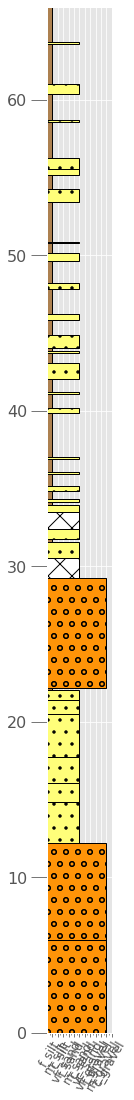

In [28]:
# the most simple plot, but doesnt include any bed-level grain size data (e.g., fining-upwards)
testseq.plot()


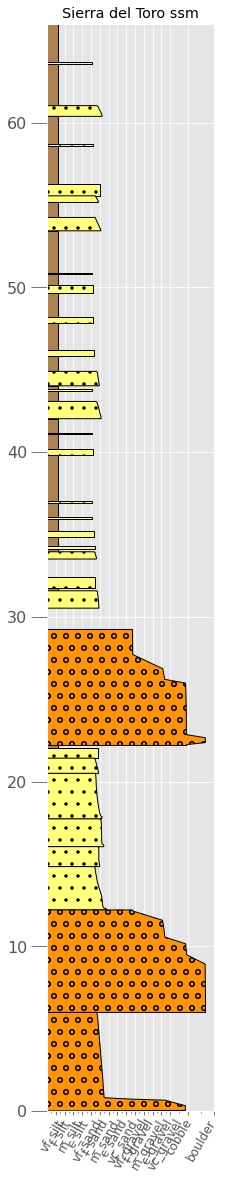

In [29]:
# here is a little nicer way to plot it that includes the grain size data for each bed

fig, ax = plt.subplots(figsize=[3,20])

testseq.plot(ax=ax,
             legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             wentworth='fine'
            )

ax.set_title(testseq.metadata['name']);

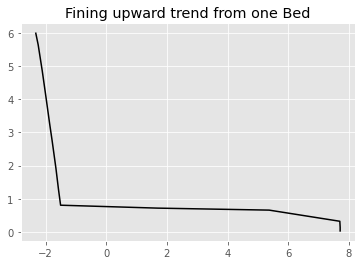

In [32]:
gs=testseq[-1].data['grain_size_psi'] # get just one field from a Bed
de=testseq[-1].data['depth_m'] 

plt.plot(gs,de,'k')
if testseq.order=='depth': 
    plt.gca().invert_yaxis()
    print('depth ordered')
    
plt.title('Fining upward trend from one Bed');

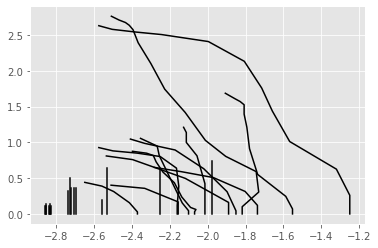

In [33]:
fig, ax = plt.subplots()
for bed in testseq:
    if bed.lithology=='sand':
        gs=bed.data['grain_size_psi']
        
        de=bed.data['depth_m']
        de=np.max(de)-de # normalize to zero so they will all plot together
        if testseq.order=='elevation':
            de=np.flip(de)
        ax.plot(gs,de,'k')

## Flipping depth -> elevation

In [ ]:
# depth version (this is only depth-ordered one in demo)
seqs[-2].plot(legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

In [ ]:
# to elevation
seqs[-2].flip_convention(depth_key='depth_m').plot(
             legend=litholog.defaults.litholegend, 
             fig_width=3, aspect=5, wentworth='coarse')

In [ ]:
# Specify a legend when plotting (otherwise random used)
# `wentworth` can use 'fine' or 'coarse' bins

# elevation_version
example_seq.plot(legend=litholog.defaults.litholegend, 
                 fig_width=3, aspect=5, wentworth='coarse')

In [ ]:
# to depth
example_seq.flip_convention(depth_key='depth_m').plot(
          legend=litholog.defaults.litholegend, 
          fig_width=3, aspect=5, wentworth='coarse')

In [ ]:
example_seq.order

In [ ]:
example_seq.shift(delta=-example_seq.stop.z).order

# Some Basic Stats Properties

In [ ]:
print(example_seq.metadata)

# Properties computed on the fly
print(example_seq.net_to_gross,';',example_seq.amalgamation_ratio)

print('N:G from Matlab:',round(example_seq.metadata['ng'],3),'\n',
      'N:G from litholog:',round(example_seq.net_to_gross,3))

In [ ]:
# Hurst statistics
print(example_seq.hurst_K('th', 'sand'))

# Returns (D, p, hurst_K)
example_seq.hurst_D('th', 'sand', nsamples=10000)

# Pseudo-gamma curves

In [ ]:
def suggest_figsize(sequence, aspect=10):
    """
    Defining default a total thickness -> figure size mapping.
    """
    suggest_h = max(10, min(sequence.cum, 50))
    suggest_w = suggest_h / aspect
    return (suggest_w, suggest_h)


def strip_fig_extra_columns(ax_num, sequence, ncols, exxon_style=True, figsize=None, aspect=10):
    """
    Creates a fig with `ncol` axes and plots `sequence` on one of them.
    If `exxon_style`, plots `sequence` on first axis, otherwise last axis.
    Returns
    -------
    fig, ax
    """
    w, h = suggest_figsize(sequence, aspect=aspect)
    print(w, h)

    fig, ax = plt.subplots(ncols=ncols, sharey=True, figsize=(w*ncols, h))
    #fig.subplots_adjust(wspace=0.)

    sequence.plot(legend=litholog.defaults.litholegend,
                  width_field='grain_size_psi',
                  depth_field='depth_m',
                  ax=ax[ax_num])

    return fig, ax

In [ ]:
#mag.resample_data('depth_m',0.01)
i=0
for bed in mag:
    np.linspace(bed.top.z, bed.base.z, max(2,int((bed.top.z-bed.base.z) // 0.01)))
    i+=1
    print(i)

In [ ]:
# Showing default values:
ds, pgr = mag.pseudo_gamma_simple(
    gs_field='grain_size_mm',
    depth_field='depth_m',
    resolution=0.2,
    gs_cutoff=0.0625,
    gamma_range=(30, 180),
    sigma=0.1,
    noise=10.
)

fig, ax = strip_fig_extra_columns(0, example_seq, 2, aspect=9)

cutoff = 100

ax[1].plot(pgr, ds, 'k')
ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

# Ignore below here for now

In [ ]:






def gradient_fill(x, y, ax, pos_or_neg,
                  fill_color=None,
                  **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    ax : a matplotlib Axes instance
        The axes to plot on.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.
    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    x[np.argwhere(np.isnan(x))] = 0.

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if pos_or_neg=='positive':
        alpha_gradient = np.linspace(0.2, alpha, 100)
        xmin, xmax = 0., ax.get_xlim()[1]
    else:
        alpha_gradient = np.linspace(alpha, 0.2, 100)
        xmin, xmax = ax.get_xlim()[0], 0.

    z = np.empty((1, 100, 4), dtype=float)
    z[:,:,-1] = alpha_gradient[None,:]

    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    ymin, ymax = y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.flipud(xy) if y[0] < y[1] else xy   # Have to flip order for 'depth'-ordered striplogs
    if pos_or_neg=='positive':
        xy = np.vstack([[xmin, ymax], xy, [xmin, ymin], [xmin, ymax]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmax, ymin], [xmax, ymax]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

# Plotting with convolution "gamma ray"

In [ ]:
# using astropy.convolve for now

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')
ax[1].set_xlim([0,200])

In [ ]:
from scipy.ndimage import gaussian_filter1d

def filter_nan_gaussian(arr, sigma):
    """

    (Allows intensity to leak into the NaN area.)

    Implementation from stackoverflow answer:
        https://stackoverflow.com/a/36307291/7128154
    """
    gauss = arr.copy()
    gauss[np.isnan(gauss)] = 0
    gauss = gaussian_filter1d(gauss, sigma=sigma, mode='constant', cval=0)

    norm = np.ones(shape=arr.shape)
    norm[np.isnan(arr)] = 0
    norm = gaussian_filter1d(norm, sigma=sigma, mode='constant', cval=0)

    # avoid RuntimeWarning: invalid value encountered in true_divide
    norm = np.where(norm==0, 1, norm)
    gauss = gauss/norm
    gauss[np.isnan(arr)] = np.nan
    return gauss

def pseudo_gamma_simple(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    gamma_range = (180, 30) # Low/High values
    resolution = 0.05       # Depth resolution
    sigma = 2              # Gaussian filter width
    noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    #kernel = Gaussian1DKernel(sigma) # divided by resolution?
    #conv_gr = convolve(sample_gr, kernel)
    conv_gr = filter_nan_gaussian(sample_gr, sigma)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


fig, ax = strip_fig_extra_columns(0, seqs[0], 2, aspect=9)

cutoff = 100

ds, gr = pseudo_gamma_simple(seqs[0])
#gradient_fill(gr, ds, ax[1], 'positive', fill_color='y')

ax[1].plot(gr, ds)
ax[1].fill_betweenx(ds, gr, np.repeat(cutoff, ds.size), where=(gr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

## these functions stolen from Matt Bauer



In [ ]:
import matplotlib as mpl

def rect(ax,x,y,w,h,c):
    #Make rectangle with plt.Rectangle((x,y@ Lower left),width,height,color)
    polygon = plt.Rectangle((x,y),w,h,color=c)
    #Add it to axis
    ax.add_patch(polygon)

def GR_fill(ax,X,Y):
    plt.plot(X,Y,lw=0)
    
    #Make a custom color ramp
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","yellow",'goldenrod','darkgoldenrod',"dimgrey",'black','black'])
    
    #Step distance
    dy = Y[1]-Y[0]
    
    #Max GR value
    N  = float(np.nanmax(X))
    
    #Make rectangles with color based on GR values
    for n, (x,y) in enumerate(zip(X,Y)):
        color = cmap(x/N)
        rect(ax,x,y,N-x,dy,color)
        
        
fig, ax = strip_fig_extra_columns(1 ,seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma_simple(seqs[0])
ax[0].plot(gr,ds,'k')
GR_fill(ax[0], gr, ds)
ax[0].set_xlim([0,200])
ax[1].set_title(seqs[0].metadata['name'])
plt.show()
#plt.savefig('/Users/zanejobe/Desktop/testT.pdf')

In [ ]:
def pseudo_gamma_args(seq, gamma_range, resolution, sigma, noise_magnitude):
    # Params that will be args in the API:
        
    gs_threshold = 0.0625   # Cutoff in mm
    #gamma_range = (180, 30) # Low/High values
    #resolution = 0.05       # Depth resolution
    #sigma = 2              # Gaussian filter width
    #noise_magnitude = 10.   # +/- noise to add
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    
    # Add noise (uniform) + restrict to positive + restore NaNs
    gr = conv_gr + np.random.uniform(-noise_magnitude, noise_magnitude, size=conv_gr.size)
    gr[gr < 0.] = 0.
    gr[nan_idxs] = np.nan
    
    return resampled_ds, gr


In [ ]:
# why NaNs here?
np.isnan(seqs[0].values).sum()

In [ ]:
seqs[-1][0].data #pukearuhue first bed

In [ ]:
# fixing weird mud bed thats a colloid at the top of the section...

# DID THIS GET CHANGED IN THE DATA FILE???
Puk=-1
seqs[Puk][0].data['gs_tops_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['mean_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['max_gs_mm'] = 0.010289315855149
seqs[Puk][0].data['grain_size_mm'] = [0.0103, 0.0103]
seqs[Puk][0].data['gs_tops_psi'] = -6.6027
seqs[Puk][0].data['mean_gs_psi'] = -6.6027
seqs[Puk][0].data['max_gs_psi'] = -6.6027
seqs[Puk][0].data['grain_size_psi'] = [-6.6012, -6.6012]

In [ ]:
# Ross, what is this for? 
demo_names = ['Pukearuhue', 'Magnolia', 'Karoo krf']
seq_rows = [beds[beds['name'].str.contains(dn)] for dn in demo_names]
demo_df = pd.concat(seq_rows)
demo_df.to_csv('../data/demo_sequences.csv', index=False)


In [ ]:
# nice way to parse data to get only BedSequences with more than 20 sand beds
seqs = list(filter(lambda s: len(s.get_field('th', 'sand')) >= 20, sequences))



## Keep for depstrat

In [ ]:
# beds is the pandas dataframe of all the beds
beds.snd_shl.value_counts()
beds[beds.snd_shl == 1].th.sum()

count = {eod : 0 for eod in beds.eod.unique()}
meters = {eod : 0 for eod in beds.eod.unique()}

for _, grp in beds.groupby('count'):
    count[grp['eod'].values[0]] += 1
    meters[grp['eod'].values[0]] += grp.th.sum()
    
avgs = {k : meters[k] / count[k] for k in count.keys()}
print(avgs)

###

weird = {problem : [] for problem in ['has_null', 'th_mismatch', 'samples_mismatch']}

for name, seq in beds.groupby('count'):
    
    if seq.isnull().any().any():
        weird['has_null'].append(name)
    
    _, elev_good = io.check_thicknesses(seq, 'tops', 'th', 'elevation')
    _, depth_good = io.check_thicknesses(seq, 'tops', 'th', 'depth')
    if not (elev_good or depth_good):
        weird['th_mismatch'].append(name)
        
    if not io.check_samples(seq, 'depth_m', 'grain_size_mm'):
        weird['samples_mismatch'].append(name)
        
weird, {k : len(v) for k, v in weird.items()}

###

beds[beds.depth_m.apply(utils.safelen) != beds.grain_size_mm.apply(utils.safelen)]

###

